# Data Import

In [1]:
# Import Dependencies 
import findspark
findspark.init()
from pyspark.sql import SparkSession
import time
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
from pyspark.sql.functions import col
import re


In [2]:
# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

24/03/19 10:04:42 WARN Utils: Your hostname, Home-iMac.local resolves to a loopback address: 127.0.0.1; using 192.168.1.3 instead (on interface en1)
24/03/19 10:04:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/19 10:04:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Read in the CSV into a DataFrame.
from pyspark import SparkFiles
path = "../data/ratings.csv"

spark.sparkContext.addFile(path)
df = spark.read.csv(SparkFiles.get("ratings.csv"), sep=",", header=True)
df.show()

+--------------------+--------------------+------+-----------+-------+-------------+--------+------+------+-------------+------------------------+-----------------+------------+----------------+-----------+-------------+---------------------+-----------------+--------------+----------------------+-------------------------+----------------------+--------------------------+-----------------------------+------------------------+
|       Rating Agency|         Corporation|Rating|Rating Date|    CIK|Binary Rating|SIC Code|Sector|Ticker|Current Ratio|Long-term Debt / Capital|Debt/Equity Ratio|Gross Margin|Operating Margin|EBIT Margin|EBITDA Margin|Pre-Tax Profit Margin|Net Profit Margin|Asset Turnover|ROE - Return On Equity|Return On Tangible Equity|ROA - Return On Assets|ROI - Return On Investment|Operating Cash Flow Per Share|Free Cash Flow Per Share|
+--------------------+--------------------+------+-----------+-------+-------------+--------+------+------+-------------+-------------------

In [4]:
# Create a temporary view of the DataFrame.
df.createOrReplaceTempView('ratings')

## Explore the data

In [5]:
# Explore the data
query = """
SELECT YEAR(`Rating Date`) as YEAR, Rating, COUNT(Rating)
FROM ratings
GROUP BY YEAR(`Rating Date`), Rating
ORDER BY YEAR(`Rating Date`), COUNT(Rating) DESC;
"""
spark.sql(query).show(500)

+----+------+-------------+
|YEAR|Rating|count(Rating)|
+----+------+-------------+
|2010|  BBB+|            6|
|2010|   BBB|            5|
|2010|    A-|            5|
|2010|  BBB-|            5|
|2010|     A|            5|
|2010|   AAA|            3|
|2010|   BB+|            3|
|2010|   BB-|            3|
|2010|    B+|            2|
|2010|    BB|            2|
|2010|   AA-|            1|
|2010|     B|            1|
|2011|   BBB|           41|
|2011|     A|           40|
|2011|  BBB-|           36|
|2011|  BBB+|           36|
|2011|   BB-|           23|
|2011|     B|           23|
|2011|    A-|           22|
|2011|   BB+|           22|
|2011|    BB|           16|
|2011|    A+|           10|
|2011|    AA|           10|
|2011|   AAA|           10|
|2011|  CCC+|            9|
|2011|    B+|            9|
|2011|    B-|            6|
|2011|   CCC|            6|
|2011|   AA-|            3|
|2011|    CC|            1|
|2011|     C|            1|
|2011|  CCC-|            1|
|2012|   BBB|       

In [6]:
query = """
SELECT YEAR(`Rating Date`) as YEAR, Sector, COUNT(Sector)
FROM ratings
GROUP BY YEAR(`Rating Date`), Sector
ORDER BY YEAR(`Rating Date`), COUNT(Sector) DESC;
"""
spark.sql(query).show(500)

+----+------+-------------+
|YEAR|Sector|count(Sector)|
+----+------+-------------+
|2010| Utils|           13|
|2010| Other|            8|
|2010| BusEq|            5|
|2010| Shops|            4|
|2010| Manuf|            4|
|2010| NoDur|            3|
|2010|  Hlth|            1|
|2010| Telcm|            1|
|2010| Chems|            1|
|2010| Money|            1|
|2011| Other|           52|
|2011| Manuf|           47|
|2011| Utils|           38|
|2011| BusEq|           35|
|2011|  Hlth|           30|
|2011| Enrgy|           27|
|2011| Telcm|           22|
|2011| Shops|           21|
|2011| NoDur|           18|
|2011| Durbl|           14|
|2011| Chems|           12|
|2011| Money|            9|
|2012| Other|          188|
|2012| Manuf|          140|
|2012| BusEq|          126|
|2012| Utils|          106|
|2012| Shops|          101|
|2012| Enrgy|           84|
|2012| NoDur|           82|
|2012|  Hlth|           74|
|2012| Telcm|           66|
|2012| Chems|           43|
|2012| Money|       

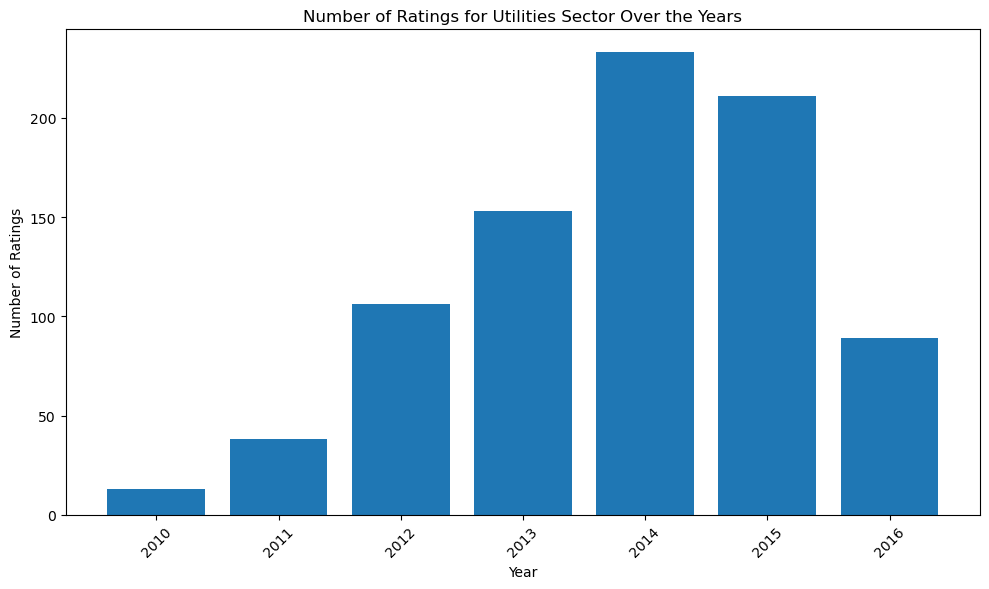

In [7]:
query = """
SELECT YEAR(`Rating Date`) as YEAR, Sector, COUNT(Sector) as SectorCount
FROM ratings
WHERE Sector = 'Utils'
GROUP BY YEAR(`Rating Date`), Sector
ORDER BY YEAR(`Rating Date`);
"""
result_df = spark.sql(query).toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(result_df['YEAR'], result_df['SectorCount'])
plt.title('Number of Ratings for Utilities Sector Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

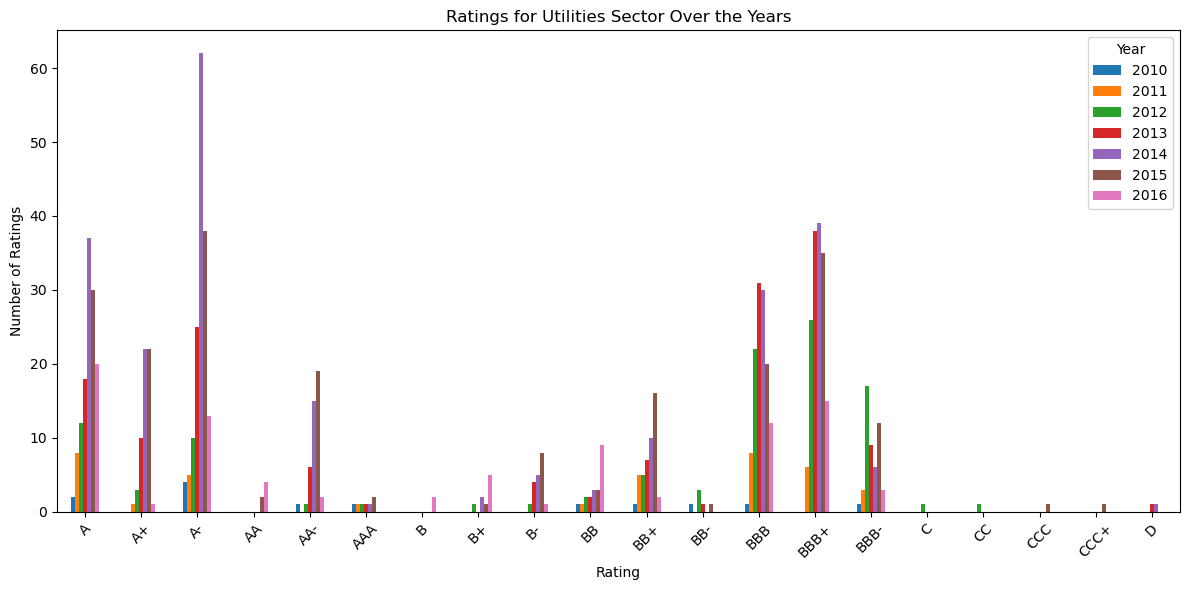

In [8]:
query = """
SELECT YEAR(`Rating Date`) as Year, Rating, COUNT(Rating) as RatingCount
FROM ratings
WHERE Sector = 'Utils'
GROUP BY YEAR(`Rating Date`), Rating
ORDER BY Year;
"""
result_df = spark.sql(query).toPandas()
# result_df.head()

pivot_df = result_df.pivot(index='Rating', columns='Year', values='RatingCount')

# Plotting
pivot_df.plot(kind='bar', figsize=(12, 6))
plt.title('Ratings for Utilities Sector Over the Years')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.legend(title='Year')
plt.tight_layout()
plt.show()

In [9]:
query = """
SELECT Rating, COUNT(*) as RatingCount
FROM ratings
GROUP BY Rating
ORDER BY RatingCount DESC
"""
spark.sql(query).show(500)

+------+-----------+
|Rating|RatingCount|
+------+-----------+
|   BBB|        910|
|  BBB+|        846|
|     A|        836|
|    A-|        722|
|  BBB-|        705|
|   BB+|        545|
|    A+|        478|
|    BB|        453|
|   BB-|        427|
|    B+|        422|
|     B|        310|
|    B-|        288|
|   AA-|        254|
|    AA|        185|
|  CCC+|        151|
|   AAA|         90|
|   AA+|         73|
|   CCC|         65|
|    CC|         18|
|     C|         11|
|  CCC-|         10|
|     D|          5|
|   CC+|          1|
+------+-----------+



In [10]:
df.printSchema()


root
 |-- Rating Agency: string (nullable = true)
 |-- Corporation: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Rating Date: string (nullable = true)
 |-- CIK: string (nullable = true)
 |-- Binary Rating: string (nullable = true)
 |-- SIC Code: string (nullable = true)
 |-- Sector: string (nullable = true)
 |-- Ticker: string (nullable = true)
 |-- Current Ratio: string (nullable = true)
 |-- Long-term Debt / Capital: string (nullable = true)
 |-- Debt/Equity Ratio: string (nullable = true)
 |-- Gross Margin: string (nullable = true)
 |-- Operating Margin: string (nullable = true)
 |-- EBIT Margin: string (nullable = true)
 |-- EBITDA Margin: string (nullable = true)
 |-- Pre-Tax Profit Margin: string (nullable = true)
 |-- Net Profit Margin: string (nullable = true)
 |-- Asset Turnover: string (nullable = true)
 |-- ROE - Return On Equity: string (nullable = true)
 |-- Return On Tangible Equity: string (nullable = true)
 |-- ROA - Return On Assets: string (null

In [11]:

# Ratings when the Binary Rating = 0
query = """
SELECT Rating, COUNT(*) AS RatingCount
FROM ratings
WHERE `Binary Rating` = '0' 
GROUP BY Rating
ORDER BY Rating;
"""
spark.sql(query).show(500)

+------+-----------+
|Rating|RatingCount|
+------+-----------+
|     B|        310|
|    B+|        422|
|    B-|        288|
|    BB|        453|
|   BB+|        545|
|   BB-|        427|
|     C|         11|
|    CC|         18|
|   CC+|          1|
|   CCC|         65|
|  CCC+|        151|
|  CCC-|         10|
|     D|          5|
+------+-----------+



In [12]:
# Ratings when the Binary Rating = 1
query = """
SELECT Rating, COUNT(*) AS RatingCount
FROM ratings
WHERE `Binary Rating` = '1' 
GROUP BY Rating
ORDER BY Rating;
"""
spark.sql(query).show(500)

+------+-----------+
|Rating|RatingCount|
+------+-----------+
|     A|        836|
|    A+|        478|
|    A-|        722|
|    AA|        185|
|   AA+|         73|
|   AA-|        254|
|   AAA|         90|
|   BBB|        910|
|  BBB+|        846|
|  BBB-|        705|
+------+-----------+



In [13]:
# Average Values for "Good Credit"
query = """
SELECT 
    AVG(CAST(`Current Ratio` AS FLOAT)) AS CurrentRatioAvg, 
    AVG(CAST(`Long-term Debt / Capital` AS FLOAT)) AS DebtCapitalAvg, 
    AVG(CAST(`Debt/Equity Ratio` AS FLOAT)) AS DebtEquityAvg, 
    AVG(CAST(`Gross Margin` AS FLOAT)) AS GrossMarginAvg, 
    AVG(CAST(`Operating Margin` AS FLOAT)) AS OperatingMarginAvg, 
    AVG(CAST(`EBIT Margin` AS FLOAT)) AS EBITMarginAvg, 
    AVG(CAST(`EBITDA Margin` AS FLOAT)) AS EBITDAMarginAvg, 
    AVG(CAST(`Pre-Tax Profit Margin` AS FLOAT)) AS PreTaxProfitMarginAvg, 
    AVG(CAST(`Net Profit Margin` AS FLOAT)) AS NetProfitMarginAvg, 
    AVG(CAST(`Asset Turnover` AS FLOAT)) AS AssetTurnoverAvg, 
    AVG(CAST(`ROE - Return On Equity` AS FLOAT)) AS ROEAvg, 
    AVG(CAST(`Return On Tangible Equity` AS FLOAT)) AS ROTEAvg, 
    AVG(CAST(`ROA - Return On Assets` AS FLOAT)) AS ROAAvg, 
    AVG(CAST(`ROI - Return On Investment` AS FLOAT)) AS ROIAvg, 
    AVG(CAST(`Operating Cash Flow Per Share` AS FLOAT)) AS CashFlowAvg, 
    AVG(CAST(`Free Cash Flow Per Share` AS FLOAT)) AS FreeCashFlowAvg 
FROM ratings
WHERE `Binary Rating` = '1';
"""
spark.sql(query).show(500)



24/03/19 10:04:48 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------------+-------------------+-----------------+-----------------+------------------+------------------+-----------------+---------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-------------------+
|   CurrentRatioAvg|     DebtCapitalAvg|    DebtEquityAvg|   GrossMarginAvg|OperatingMarginAvg|     EBITMarginAvg|  EBITDAMarginAvg|PreTaxProfitMarginAvg|NetProfitMarginAvg|  AssetTurnoverAvg|            ROEAvg|          ROTEAvg|           ROAAvg|            ROIAvg|       CashFlowAvg|    FreeCashFlowAvg|
+------------------+-------------------+-----------------+-----------------+------------------+------------------+-----------------+---------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-------------------+
|1.7000416172505781|0.39154163572461703|0.571551497270132|45.04492034338624|15.263

In [14]:
# Average Values for "Good Credit"
query = """
SELECT 
    AVG(CAST(`Current Ratio` AS FLOAT)) AS CurrentRatioAvg, 
    AVG(CAST(`Long-term Debt / Capital` AS FLOAT)) AS DebtCapitalAvg, 
    AVG(CAST(`Debt/Equity Ratio` AS FLOAT)) AS DebtEquityAvg, 
    AVG(CAST(`Gross Margin` AS FLOAT)) AS GrossMarginAvg, 
    AVG(CAST(`Operating Margin` AS FLOAT)) AS OperatingMarginAvg, 
    AVG(CAST(`EBIT Margin` AS FLOAT)) AS EBITMarginAvg, 
    AVG(CAST(`EBITDA Margin` AS FLOAT)) AS EBITDAMarginAvg, 
    AVG(CAST(`Pre-Tax Profit Margin` AS FLOAT)) AS PreTaxProfitMarginAvg, 
    AVG(CAST(`Net Profit Margin` AS FLOAT)) AS NetProfitMarginAvg, 
    AVG(CAST(`Asset Turnover` AS FLOAT)) AS AssetTurnoverAvg, 
    AVG(CAST(`ROE - Return On Equity` AS FLOAT)) AS ROEAvg, 
    AVG(CAST(`Return On Tangible Equity` AS FLOAT)) AS ROTEAvg, 
    AVG(CAST(`ROA - Return On Assets` AS FLOAT)) AS ROAAvg, 
    AVG(CAST(`ROI - Return On Investment` AS FLOAT)) AS ROIAvg, 
    AVG(CAST(`Operating Cash Flow Per Share` AS FLOAT)) AS CashFlowAvg, 
    AVG(CAST(`Free Cash Flow Per Share` AS FLOAT)) AS FreeCashFlowAvg 
FROM ratings
WHERE `Binary Rating` = '0';
"""
spark.sql(query).show(500)


+------------------+------------------+-------------------+------------------+------------------+-----------------+------------------+---------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+-------------------+-------------------+
|   CurrentRatioAvg|    DebtCapitalAvg|      DebtEquityAvg|    GrossMarginAvg|OperatingMarginAvg|    EBITMarginAvg|   EBITDAMarginAvg|PreTaxProfitMarginAvg| NetProfitMarginAvg|  AssetTurnoverAvg|           ROEAvg|           ROTEAvg|            ROAAvg|            ROIAvg|        CashFlowAvg|    FreeCashFlowAvg|
+------------------+------------------+-------------------+------------------+------------------+-----------------+------------------+---------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+-------------------+-------------------+
|2.3526830720300156|0.5682417183037755|-0.5654602079360223|37.51389

In [15]:
# Create a database
conn = sqlite3.connect('../data/db.sqlite')
conn.close()

# Connect to the database
conn = sqlite3.connect('../data/db.sqlite')

# Import CSV into database
df = pd.read_csv('../data/ratings.csv')
conn.close()


In [16]:
df.head()

,Rating Agency,Corporation,Rating,Rating Date,CIK,Binary Rating,SIC Code,Sector,Ticker,Current Ratio,...,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
0,Standard & Poor's Ratings Services,American States Water Co.,A-,2010-07-30,1056903,1,4941.0,Utils,AWR,1.1507,...,28.9834,13.6093,8.3224,0.3173,8.1724,8.1978,2.6385,4.4530,1.9957,-0.1333
1,Standard & Poor's Ratings Services,Automatic Data Processing Inc.,AAA,2010-09-16,8670,1,7374.0,BusEq,ADP,1.1129,...,23.9379,20.8699,13.5690,0.3324,22.0354,47.2858,4.4944,21.8765,0.2501,0.3132
2,Standard & Poor's Ratings Services,Avnet Inc.,BBB-,2010-11-23,8858,1,5065.0,Shops,AVT,1.9276,...,3.6338,3.0536,2.1418,2.4620,13.6376,16.7991,5.2731,9.6494,-7.6079,-7.3231
3,Standard & Poor's Ratings Services,California Water Service Co.,AA-,2010-06-29,1035201,1,4941.0,Utils,CWT,0.8358,...,27.9377,15.1135,9.0246,0.2946,9.6412,9.7015,2.6583,5.1018,1.7438,-0.8999
4,Standard & Poor's Ratings Services,Cardinal Health Inc.,A,2010-07-14,721371,1,5122.0,Shops,CAH,1.2931,...,1.5847,1.2304,0.6518,4.9276,11.1256,19.4184,2.9364,8.1844,1.9725,2.4174


In [17]:
df.columns

Index(['Rating Agency', 'Corporation', 'Rating', 'Rating Date', 'CIK',
       'Binary Rating', 'SIC Code', 'Sector', 'Ticker', 'Current Ratio',
       'Long-term Debt / Capital', 'Debt/Equity Ratio', 'Gross Margin',
       'Operating Margin', 'EBIT Margin', 'EBITDA Margin',
       'Pre-Tax Profit Margin', 'Net Profit Margin', 'Asset Turnover',
       'ROE - Return On Equity', 'Return On Tangible Equity',
       'ROA - Return On Assets', 'ROI - Return On Investment',
       'Operating Cash Flow Per Share', 'Free Cash Flow Per Share'],
      dtype='object')

## Graphing Distribution and Outliers

In [18]:
# Creating filters for Poor Credit and Good Credit
df_rating_0 = df[df['Binary Rating'] == 0]
df_rating_1 = df[df['Binary Rating'] == 1]



In [19]:
# Function will show a box plot comparing the distribution of poor credit and good credit among various features. It will also show a distribution of the feature for both good and poor credit. 

def visualize_data(t, df_rating_0, df_rating_1, df):
    plt.figure(figsize=(8, 6)) 
    plt.boxplot([df_rating_0[t], df_rating_1[t]],
                 notch=True, vert=True, patch_artist=True, labels=['Poor Credit', 'Good Credit'])

    plt.xlabel(t)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {t} by Binary Ratings')
    plt.grid(True)
    # t2 removes slashes and spaces from the column name when using to save the charts
    t2 = re.sub(r'[ /]', '_', t)
    plt.savefig(f'../img/{t2}_box.png')
    plt.show()

    plt.hist(df[t])

    plt.xlabel(t)
    plt.ylabel('Frequency')
    plt.title(f'Total Distribution of {t}')
    plt.savefig(f'../img/{t2}_hist.png')
    plt.show()
    print(df[t].describe())


In [20]:
df.columns

Index(['Rating Agency', 'Corporation', 'Rating', 'Rating Date', 'CIK',
       'Binary Rating', 'SIC Code', 'Sector', 'Ticker', 'Current Ratio',
       'Long-term Debt / Capital', 'Debt/Equity Ratio', 'Gross Margin',
       'Operating Margin', 'EBIT Margin', 'EBITDA Margin',
       'Pre-Tax Profit Margin', 'Net Profit Margin', 'Asset Turnover',
       'ROE - Return On Equity', 'Return On Tangible Equity',
       'ROA - Return On Assets', 'ROI - Return On Investment',
       'Operating Cash Flow Per Share', 'Free Cash Flow Per Share'],
      dtype='object')

Processing column: Current Ratio


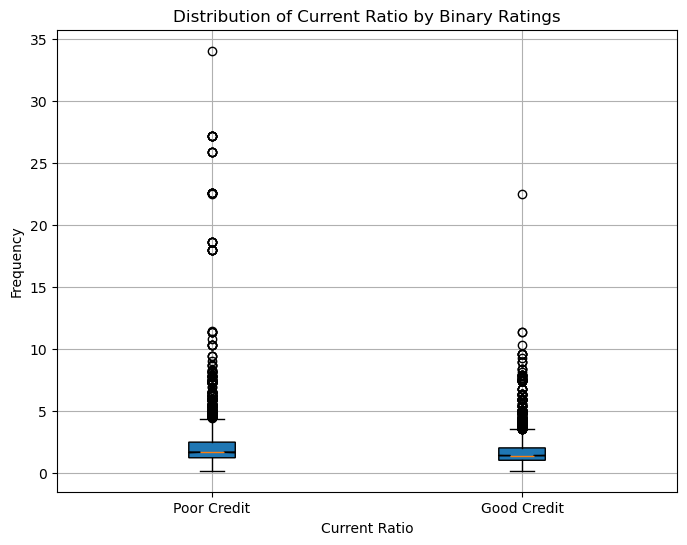

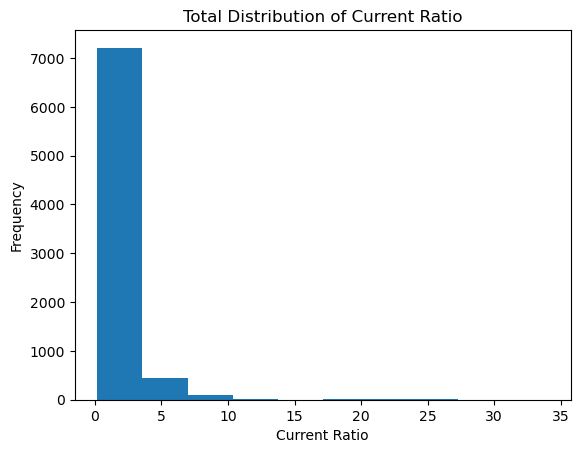

count    7805.000000
mean        1.926313
std         1.921651
min         0.174900
25%         1.077300
50%         1.496800
75%         2.161000
max        34.076800
Name: Current Ratio, dtype: float64
Processing column: Long-term Debt / Capital


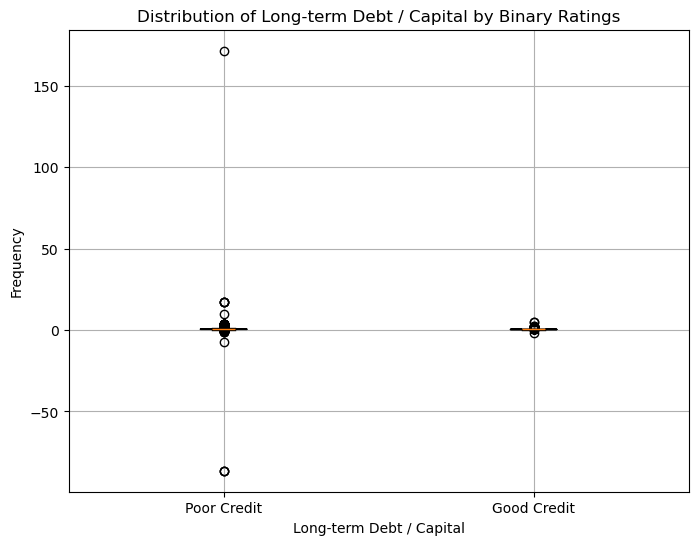

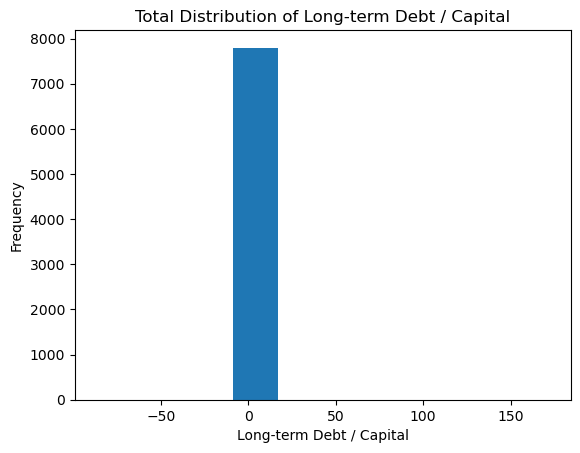

count    7805.000000
mean        0.452804
std         2.629158
min       -86.363600
25%         0.286500
50%         0.427200
75%         0.542200
max       171.500000
Name: Long-term Debt / Capital, dtype: float64
Processing column: Debt/Equity Ratio


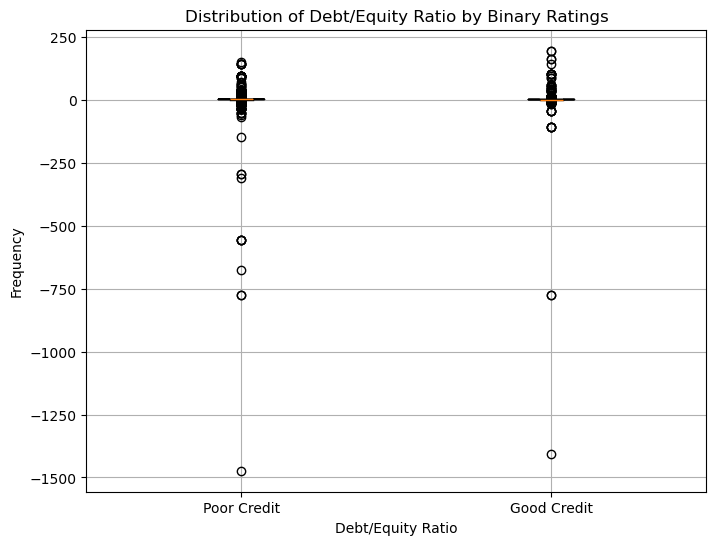

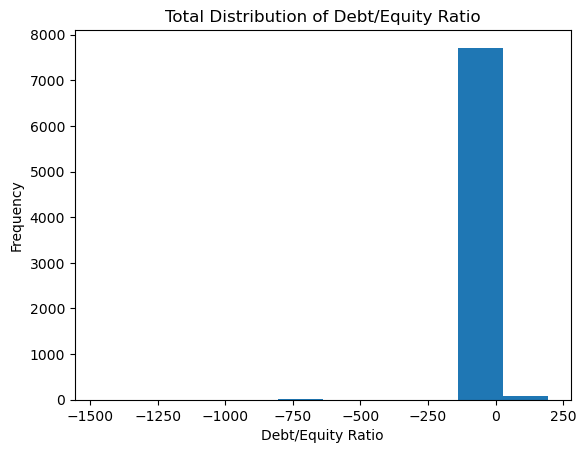

count    7805.000000
mean        0.177349
std        34.456334
min     -1473.098000
25%         0.419700
50%         0.752800
75%         1.211600
max       194.375000
Name: Debt/Equity Ratio, dtype: float64
Processing column: Gross Margin


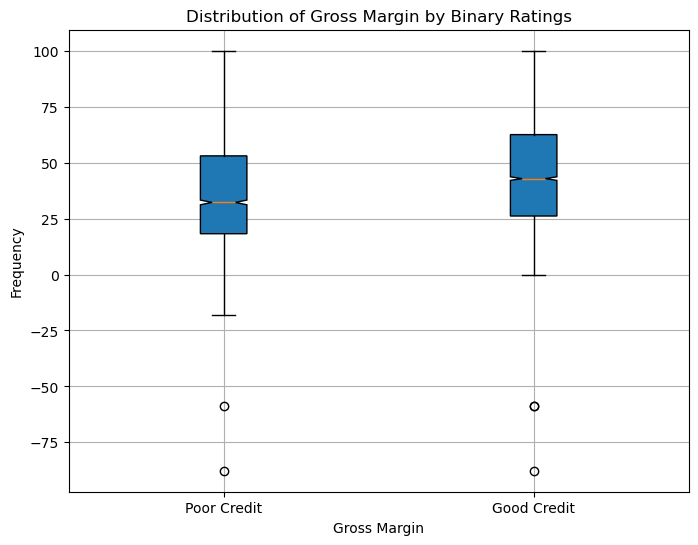

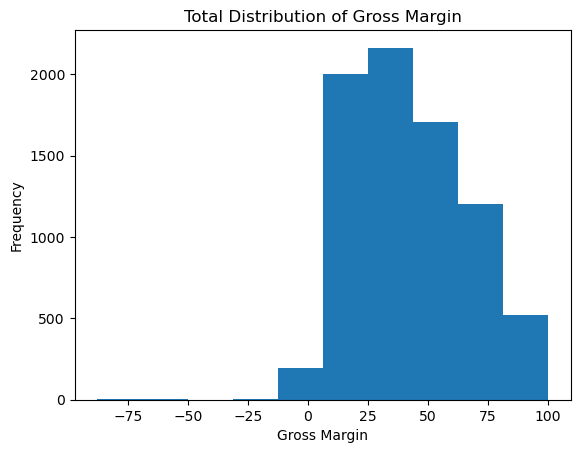

count    7805.000000
mean       42.433909
std        23.742020
min       -87.684000
25%        22.453900
50%        39.635400
75%        59.641700
max       100.000000
Name: Gross Margin, dtype: float64
Processing column: Operating Margin


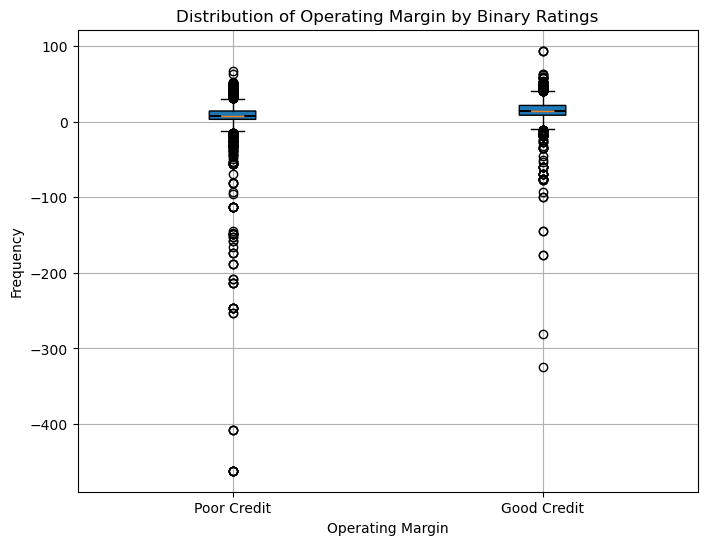

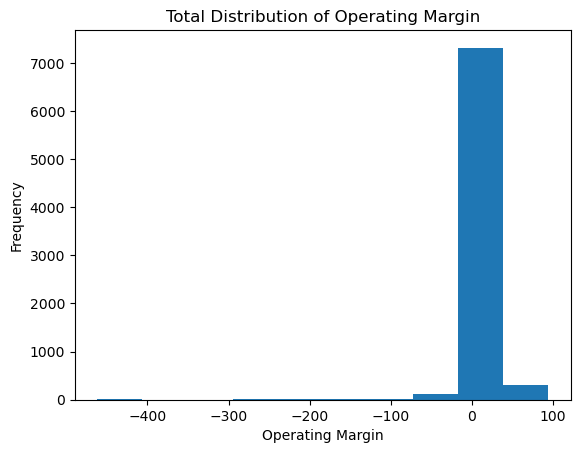

count    7805.000000
mean       11.531612
std        25.469044
min      -461.787800
25%         6.098200
50%        12.120100
75%        19.464600
max        93.993000
Name: Operating Margin, dtype: float64
Processing column: EBIT Margin


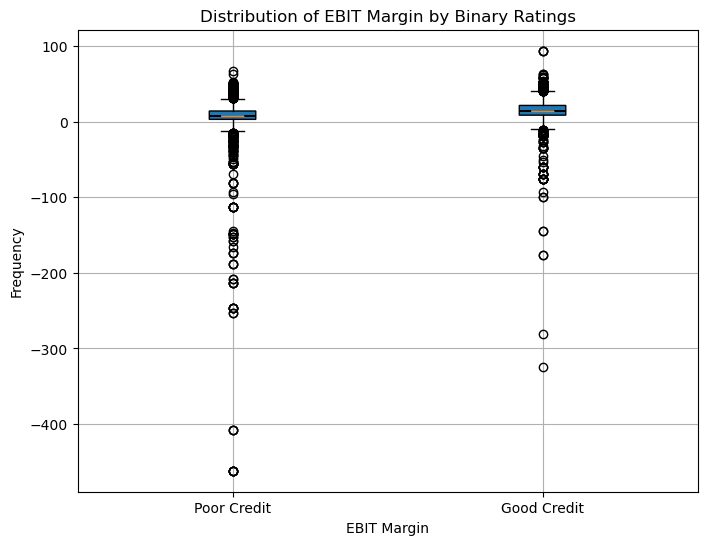

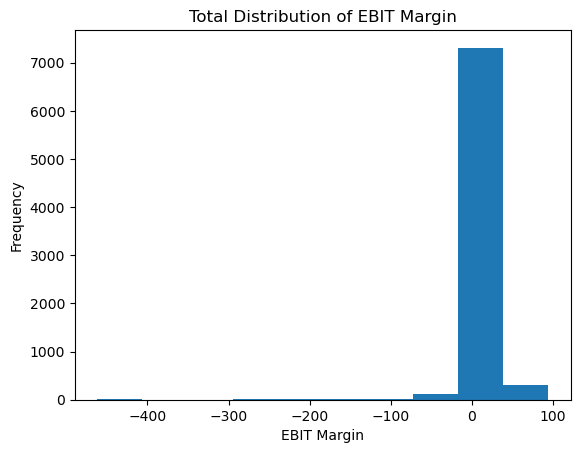

count    7805.000000
mean       11.582683
std        25.483934
min      -461.787800
25%         6.181100
50%        12.155800
75%        19.539900
max        93.993000
Name: EBIT Margin, dtype: float64
Processing column: EBITDA Margin


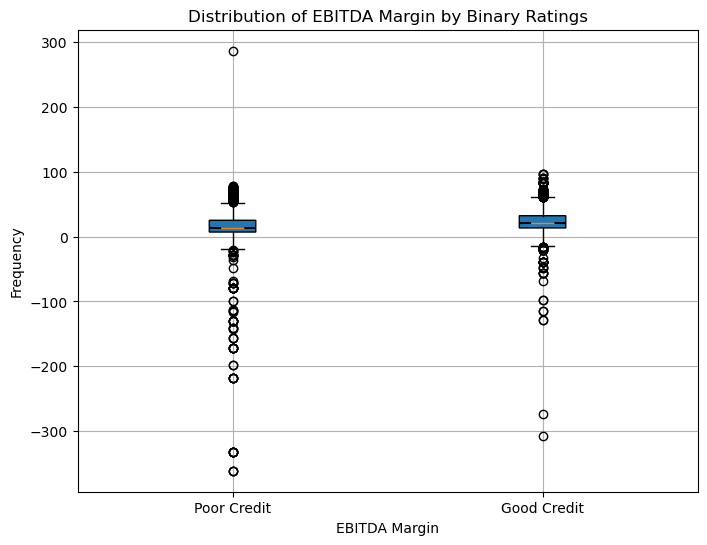

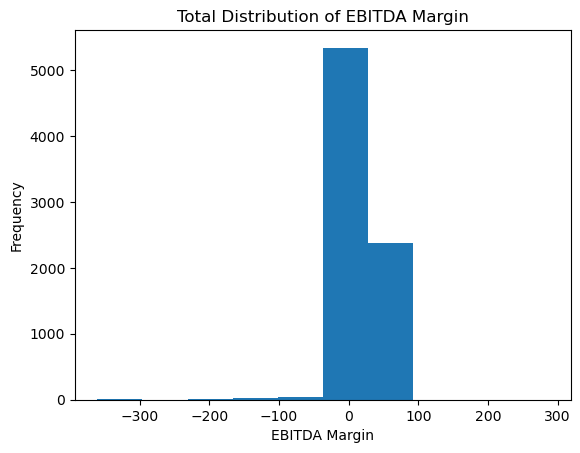

count    7805.000000
mean       20.071493
std        24.380407
min      -360.816900
25%        11.162100
50%        18.304500
75%        30.661600
max       286.493500
Name: EBITDA Margin, dtype: float64
Processing column: Pre-Tax Profit Margin


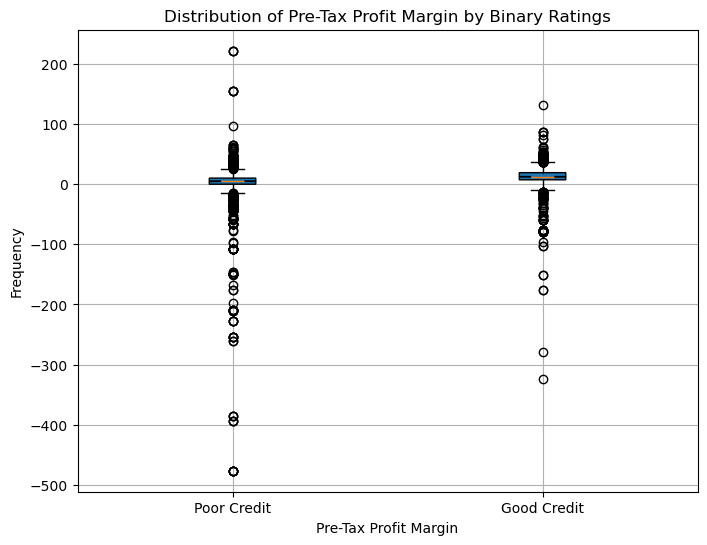

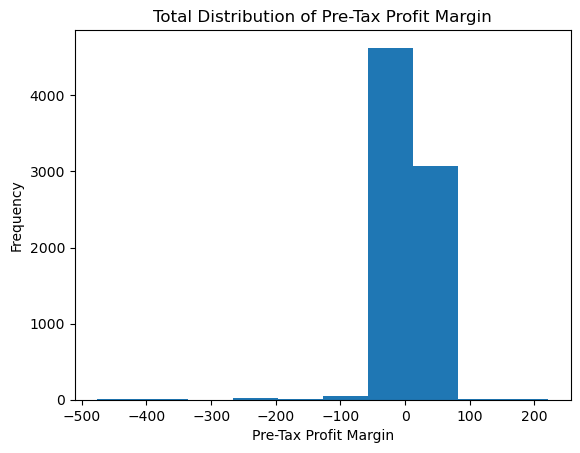

count    7805.000000
mean        8.659944
std        27.866408
min      -476.010000
25%         4.008700
50%         9.705100
75%        16.676900
max       221.289400
Name: Pre-Tax Profit Margin, dtype: float64
Processing column: Net Profit Margin


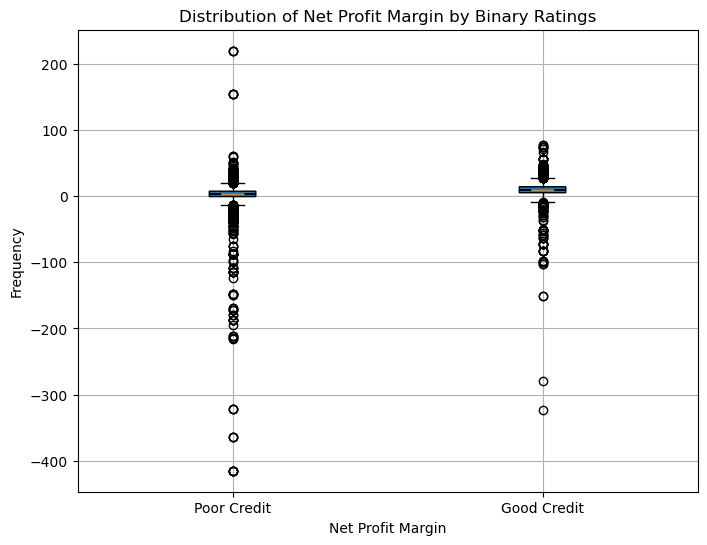

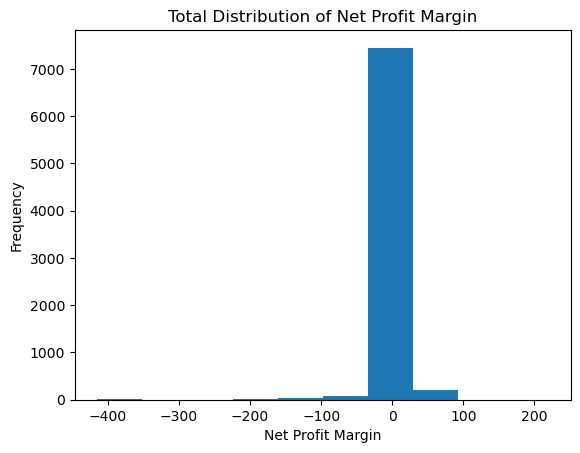

count    7805.000000
mean        5.995566
std        24.055577
min      -414.824800
25%         2.637100
50%         6.938900
75%        12.366700
max       219.390300
Name: Net Profit Margin, dtype: float64
Processing column: Asset Turnover


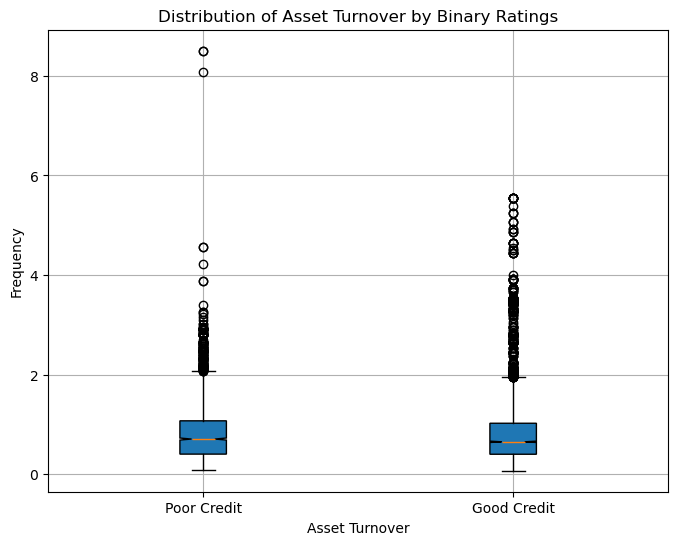

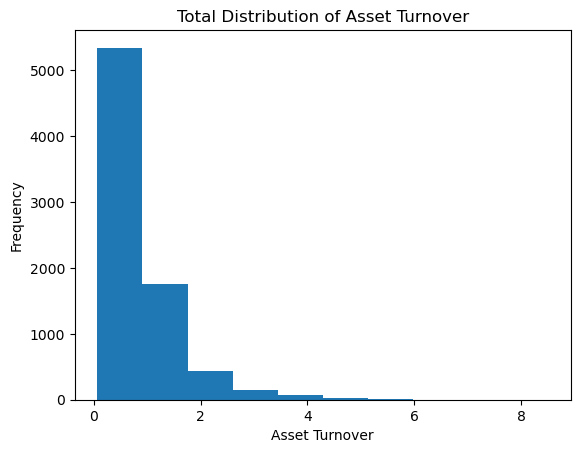

count    7805.000000
mean        0.849843
std         0.696204
min         0.068400
25%         0.399500
50%         0.661200
75%         1.038800
max         8.503900
Name: Asset Turnover, dtype: float64
Processing column: ROE - Return On Equity


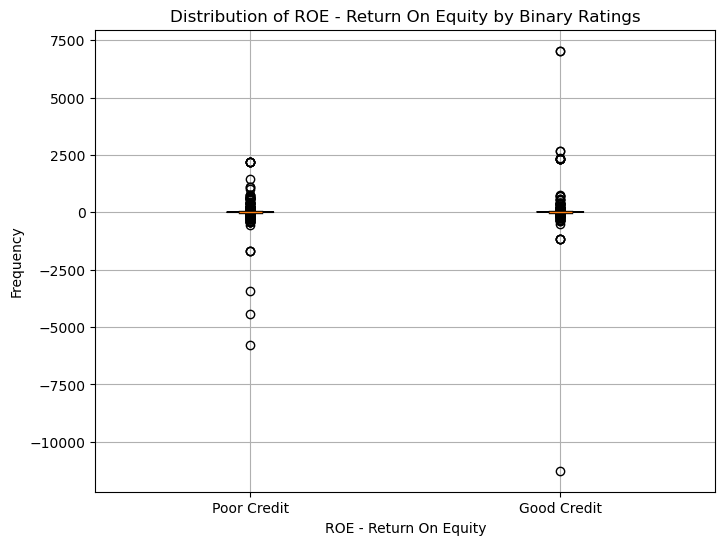

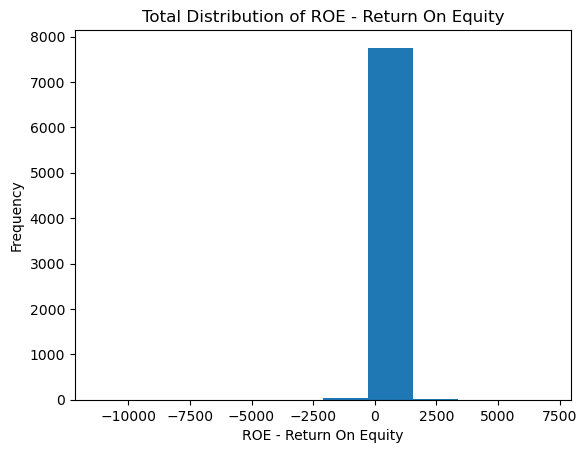

count     7805.000000
mean        15.950507
std        230.592526
min     -11258.210000
25%          6.022800
50%         12.500000
75%         20.515700
max       7038.461000
Name: ROE - Return On Equity, dtype: float64
Processing column: Return On Tangible Equity


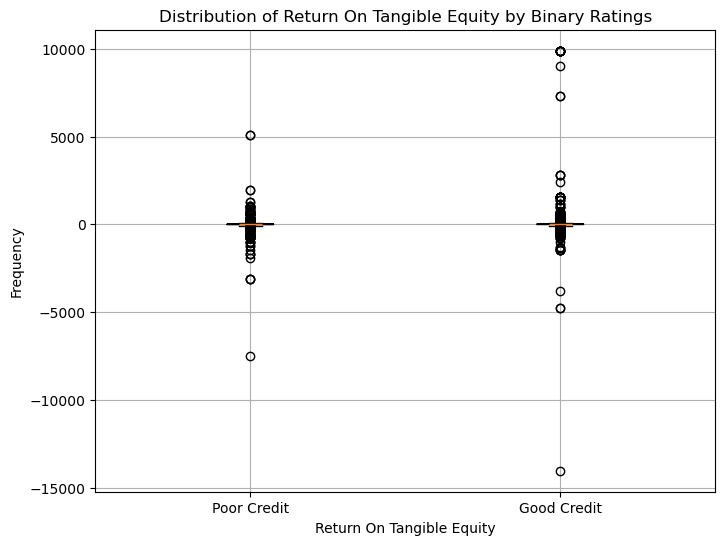

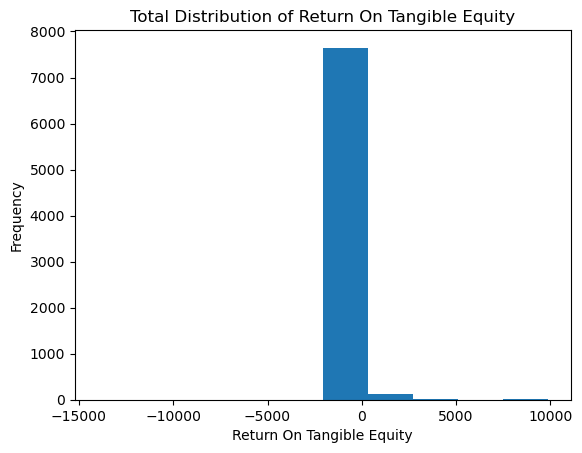

count     7805.000000
mean        21.481589
std        462.734075
min     -14023.260000
25%        -12.233900
50%         10.564100
75%         26.894100
max       9882.979000
Name: Return On Tangible Equity, dtype: float64
Processing column: ROA - Return On Assets


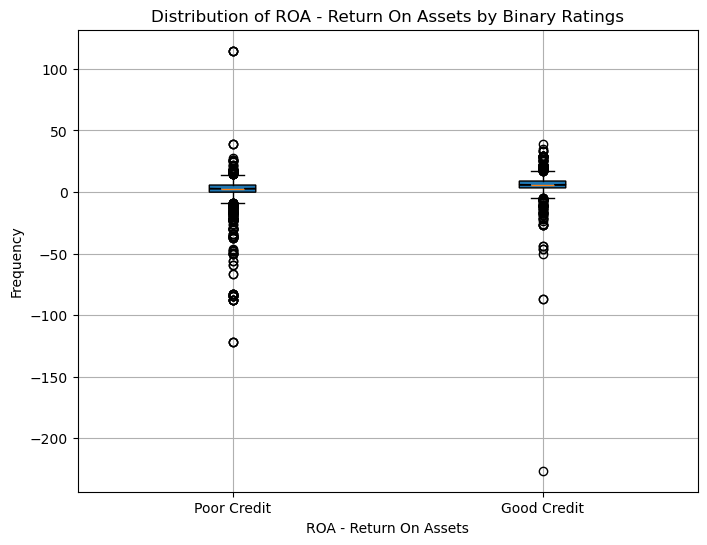

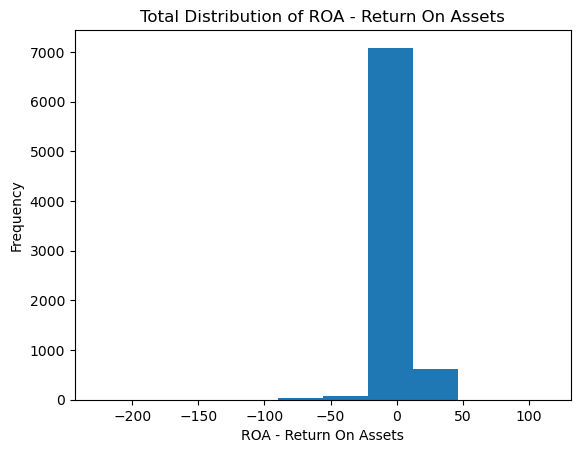

count    7805.000000
mean        4.575705
std         9.229899
min      -226.442500
25%         2.391900
50%         4.767500
75%         7.881300
max       114.716900
Name: ROA - Return On Assets, dtype: float64
Processing column: ROI - Return On Investment


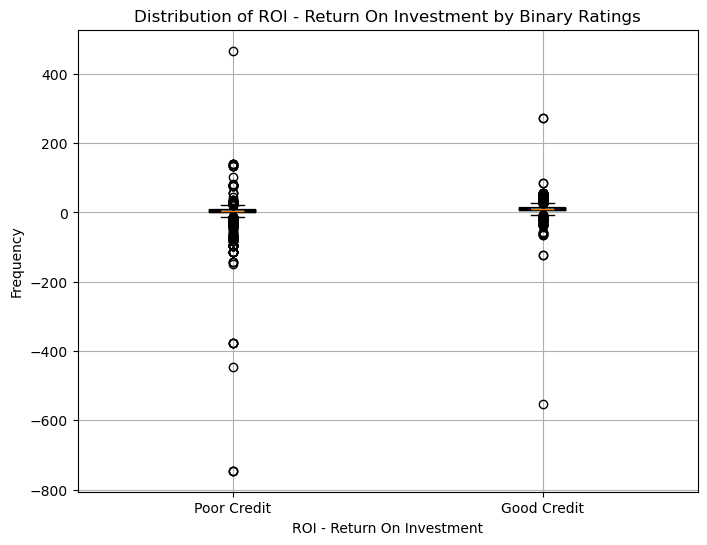

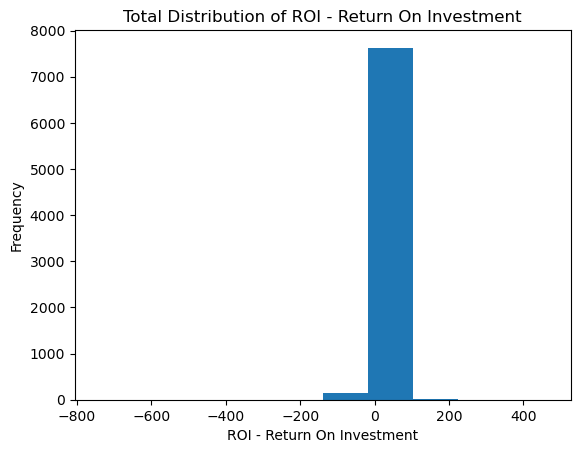

count    7805.000000
mean        7.076084
std        24.382027
min      -745.454500
25%         3.692600
50%         7.440800
75%        12.515100
max       466.666700
Name: ROI - Return On Investment, dtype: float64
Processing column: Operating Cash Flow Per Share


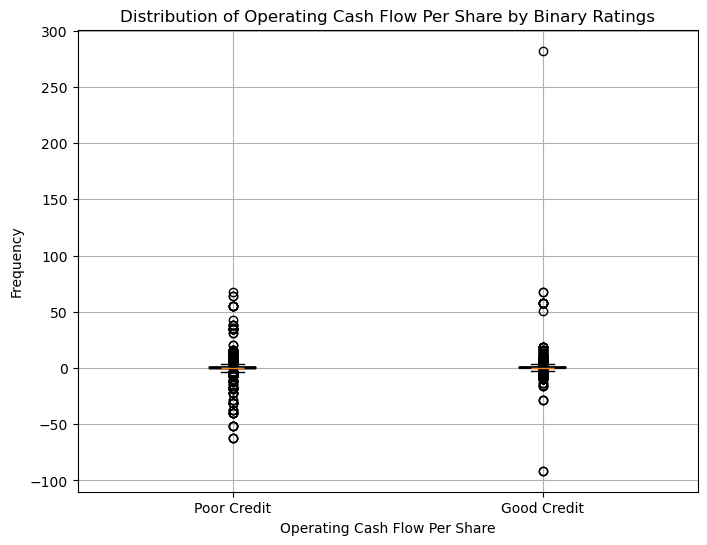

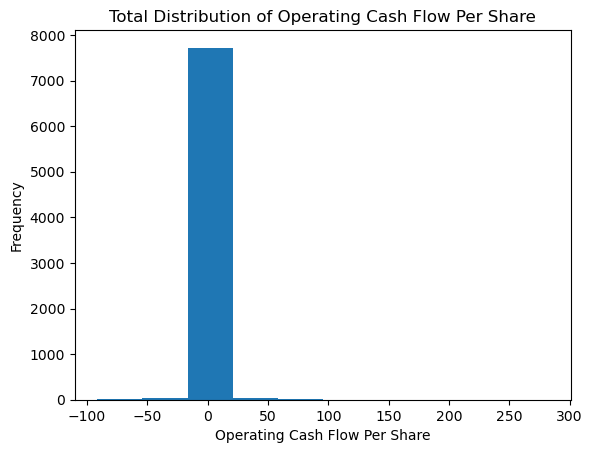

count    7805.000000
mean        0.479756
std         6.050626
min       -91.330200
25%        -0.448500
50%         0.237800
75%         1.088800
max       282.192100
Name: Operating Cash Flow Per Share, dtype: float64
Processing column: Free Cash Flow Per Share


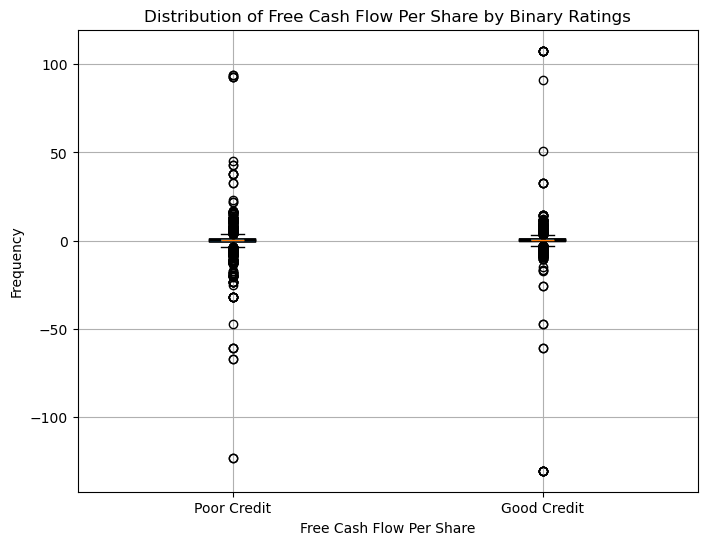

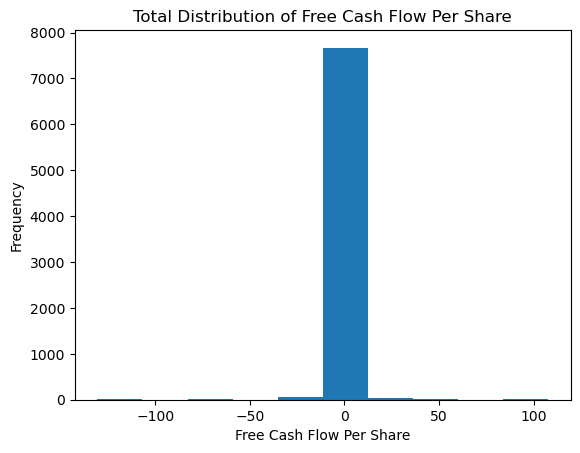

count    7805.000000
mean        0.119491
std         7.253660
min      -130.665800
25%        -0.723700
50%         0.133500
75%         0.997800
max       107.737700
Name: Free Cash Flow Per Share, dtype: float64


In [21]:
col_list = ['Current Ratio',
       'Long-term Debt / Capital', 'Debt/Equity Ratio', 'Gross Margin',
       'Operating Margin', 'EBIT Margin', 'EBITDA Margin',
       'Pre-Tax Profit Margin', 'Net Profit Margin', 'Asset Turnover',
       'ROE - Return On Equity', 'Return On Tangible Equity',
       'ROA - Return On Assets', 'ROI - Return On Investment',
       'Operating Cash Flow Per Share', 'Free Cash Flow Per Share']

for t in col_list:
    print(f"Processing column: {t}")
    visualize_data(t, df_rating_0, df_rating_1, df)

In [22]:
df.head(2)

,Rating Agency,Corporation,Rating,Rating Date,CIK,Binary Rating,SIC Code,Sector,Ticker,Current Ratio,...,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
0,Standard & Poor's Ratings Services,American States Water Co.,A-,2010-07-30,1056903,1,4941.0,Utils,AWR,1.1507,...,28.9834,13.6093,8.3224,0.3173,8.1724,8.1978,2.6385,4.4530,1.9957,-0.1333
1,Standard & Poor's Ratings Services,Automatic Data Processing Inc.,AAA,2010-09-16,8670,1,7374.0,BusEq,ADP,1.1129,...,23.9379,20.8699,13.5690,0.3324,22.0354,47.2858,4.4944,21.8765,0.2501,0.3132


In [23]:
df['Sector'].value_counts()

Sector
Other    1251
Manuf     981
BusEq     958
Utils     843
Shops     786
Enrgy     665
Hlth      625
NoDur     567
Telcm     386
Chems     315
Durbl     221
Money     207
Name: count, dtype: int64

In [24]:
df['Sector'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 7805 entries, 0 to 7804
Series name: Sector
Non-Null Count  Dtype 
--------------  ----- 
7805 non-null   object
dtypes: object(1)
memory usage: 61.1+ KB


In [25]:

def sector_chart(sector):
    filtered_df_1 = df[(df['Sector'] == sector) & (df['Binary Rating'] == 1)]
    ratingCount1 = filtered_df_1['Binary Rating'].count()

    filtered_df_0 = df[(df['Sector'] == sector) & (df['Binary Rating'] == 0)]
    ratingCount0 = filtered_df_0['Binary Rating'].count()

    plt.bar(['Poor Credit', 'Good Credit'], [ratingCount0, ratingCount1])
    plt.xlabel('Credit Rating')
    plt.ylabel('Count')
    plt.title(f'Counts of Credit Ratings in the {sector} sector')
    plt.savefig(f'../img/{sector}_bar.png')
    plt.show()

Processing sector: Utils


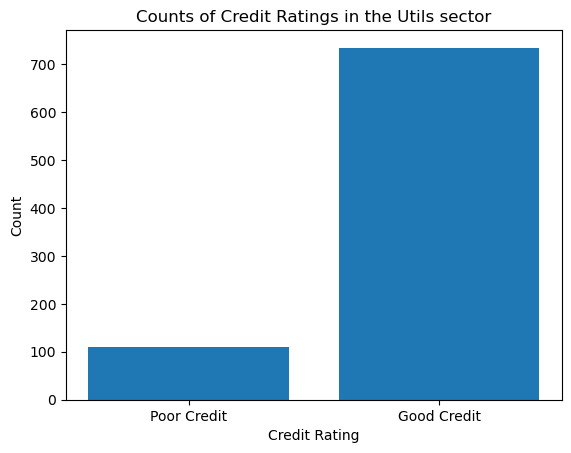

Processing sector: BusEq


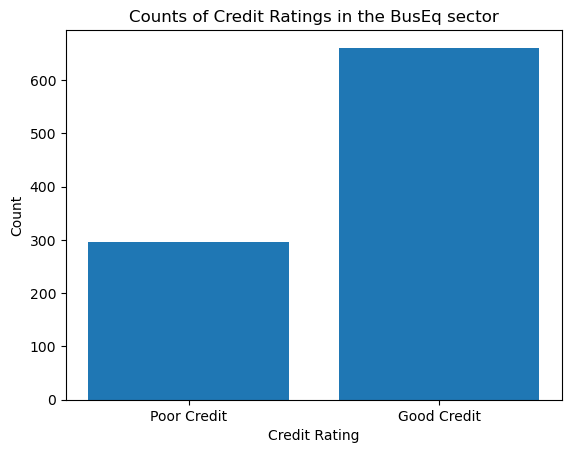

Processing sector: Shops


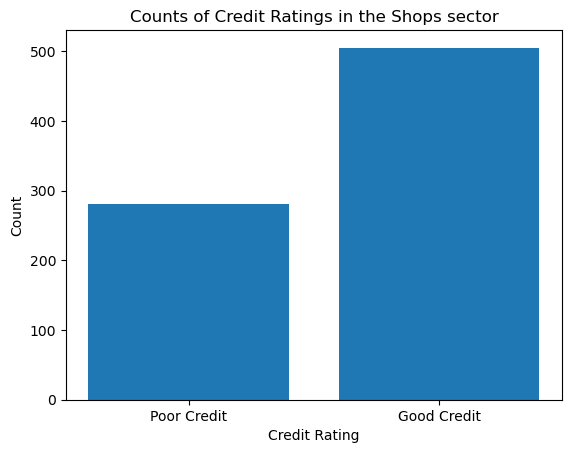

Processing sector: Manuf


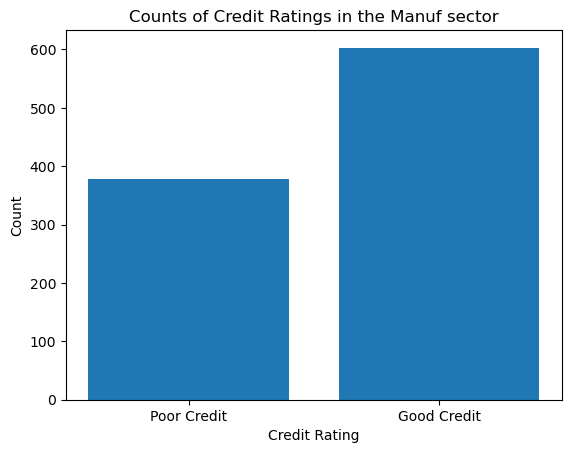

Processing sector: NoDur


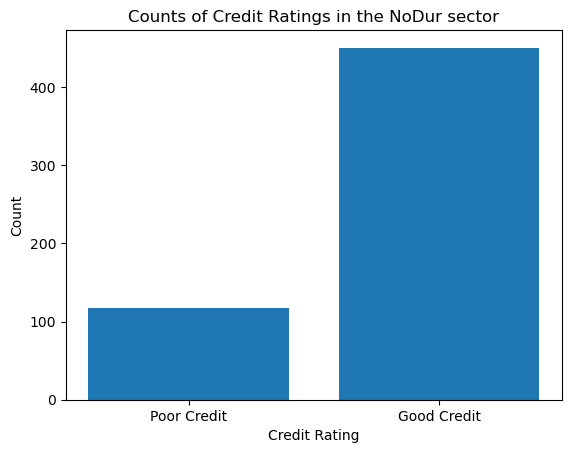

Processing sector: Other


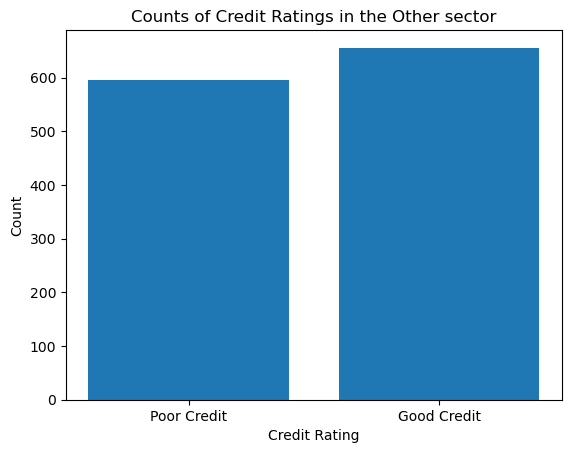

Processing sector: Chems


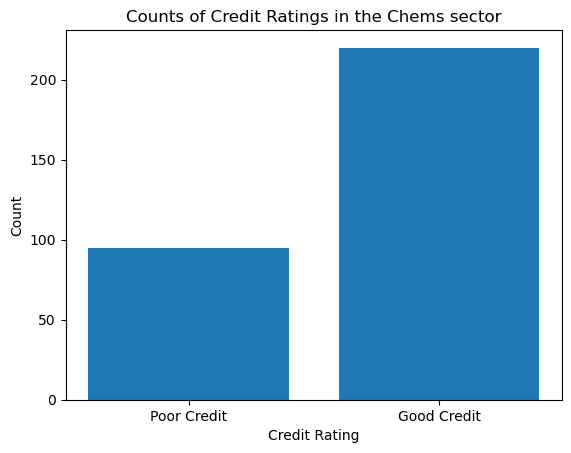

Processing sector: Telcm


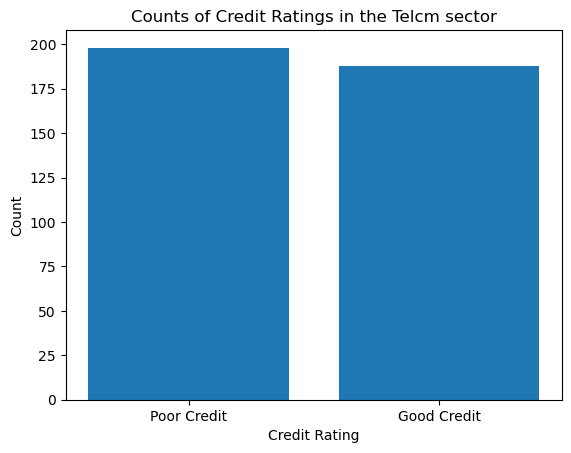

Processing sector: Hlth


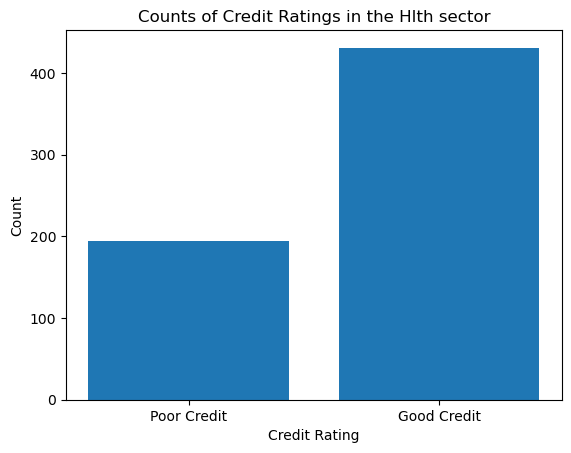

Processing sector: Money


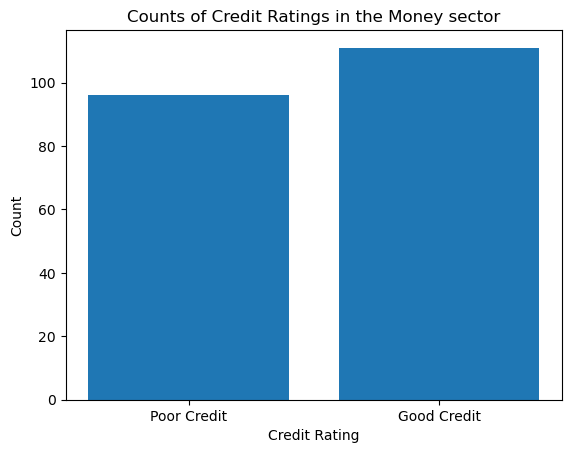

Processing sector: Durbl


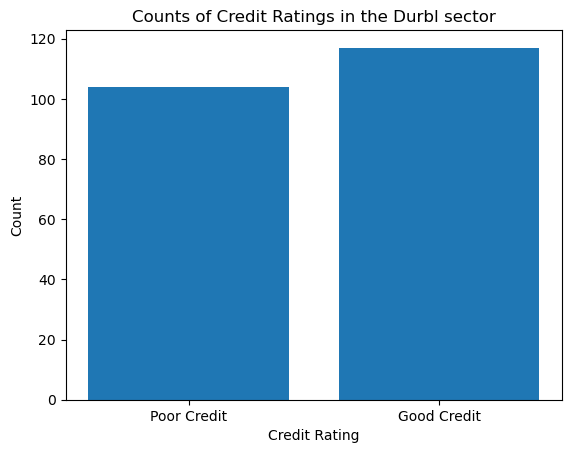

Processing sector: Enrgy


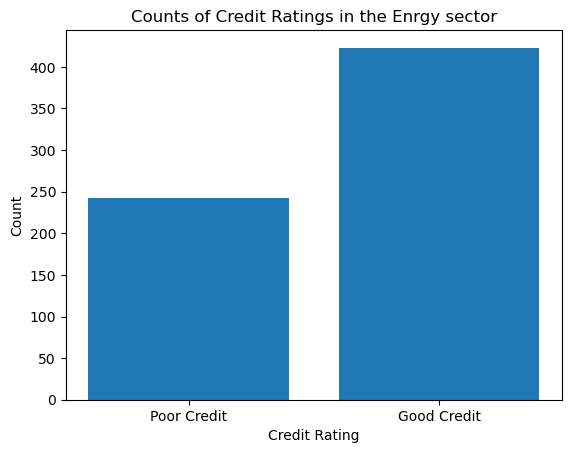

In [26]:
for sector in df['Sector'].unique():
    print(f"Processing sector: {sector}")
    sector_chart(sector)

In [27]:
# Sector information appears useful so converting to numeric data
secDict = {"Other": 1, "Manuf": 2, "BusEq": 3, "Utils": 4, "Shops": 5, "Enrgy": 6, "Hlth": 7, "NoDur": 8, "Telcm": 9, "Chems": 10, "Durbl": 11, "Money": 12}
df['Sector'] = df['Sector'].replace(secDict)
df.sample(10)

,Rating Agency,Corporation,Rating,Rating Date,CIK,Binary Rating,SIC Code,Sector,Ticker,Current Ratio,...,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
7378,Moody's Investors Service,MGM Resorts International,B+,2016-04-26,789570,0,7990.0,1,MGM,0.8883,...,21.5925,4.0754,-1.4865,0.3791,1.6672,34.7189,0.4782,0.6224,-0.3728,-1.0226
6095,Egan-Jones Ratings Company,NORTHWEST NATURAL GAS COMPANY,A+,2015-11-30,73020,1,4924.0,4,NWN,0.7724,...,32.0267,13.3064,7.7837,0.2460,7.6490,7.6489,1.9149,4.2254,1.3955,1.8110
7513,Standard & Poor's Ratings Services,Packaging Corp. of America,BBB,2016-08-15,75677,1,2650.0,2,PKG,2.4597,...,18.6840,10.4962,6.6107,1.1100,25.8052,57.6421,7.4458,10.0845,1.3429,-0.5805
6873,Standard & Poor's Ratings Services,Amcor Ltd.,BBB,2016-03-23,1748790,1,2670.0,2,AMCR,1.8995,...,13.9436,8.9380,5.8776,1.1667,20.0348,223.7741,6.9316,9.4444,0.6257,0.5448
3677,Egan-Jones Ratings Company,HERSHEY COMPANY,A+,2014-05-14,47111,1,2060.0,8,HSY,1.4367,...,19.8846,15.2851,9.9474,1.3974,63.0435,269.0465,13.9002,25.6240,2.2380,2.5329
5434,Egan-Jones Ratings Company,"ENPRO INDUSTRIES, INC.",BB,2015-03-23,1164863,0,3050.0,2,NPO,2.1757,...,9.9155,2.6737,1.8043,0.7608,3.5268,11.6649,1.3727,1.8617,-1.7264,-2.0557
710,Standard & Poor's Ratings Services,Eastman Chemical Co.,BBB,2012-05-29,915389,1,2821.0,10,EMN,1.9131,...,19.2400,10.6128,7.2749,0.9759,25.6915,33.3866,6.9830,12.9612,-1.2731,-1.0027
4602,Standard & Poor's Ratings Services,Trimas Company LLC,BB-,2014-05-27,842633,0,3460.0,2,TRS,1.9694,...,16.2674,9.5223,9.4473,0.6148,10.7825,292.9768,4.5542,7.0118,0.1870,0.8170
12,Standard & Poor's Ratings Services,FMC Technologies Inc.,A,2010-12-10,1135152,1,3533.0,2,FTI,1.2307,...,22.2616,15.8340,9.9892,0.6739,12.6645,-52.2393,6.7318,9.1905,4.7202,4.1827
4094,Standard & Poor's Ratings Services,Nabors Industries Inc.,BBB,2014-04-03,1163739,1,1381.0,6,NBR,2.7666,...,24.0786,4.1853,2.4908,0.5229,3.9109,4.2476,1.8408,2.2539,18.3050,107.7377


In [28]:
df['Rating Agency'].value_counts()

Rating Agency
Egan-Jones Ratings Company            2826
Standard & Poor's Ratings Services    2813
Moody's Investors Service             1636
Fitch Ratings                          477
DBRS                                    26
Japan Credit Rating Agency,Ltd.         22
HR Ratings de Mexico S.A. de C.V.        5
Name: count, dtype: int64

In [29]:
test= "Standard & Poor's Ratings Services"
t3 = test[:2]
print(t3)

St


In [30]:
def agency_Chart(agency, a2):
    filtered_df_1 = df[(df['Rating Agency'] == agency) & (df['Binary Rating'] == 1)]
    ratingCount1 = filtered_df_1['Binary Rating'].count()

    filtered_df_0 = df[(df['Rating Agency'] == agency) & (df['Binary Rating'] == 0)]
    ratingCount0 = filtered_df_0['Binary Rating'].count()
    
    plt.bar(['Poor Credit', 'Good Credit'], [ratingCount0, ratingCount1])
    plt.xlabel('Agency Name')
    plt.ylabel('Count')
    plt.title(f'Counts of Agencys by {agency}')

    plt.savefig(f'../img/{a2}_bar.png')
    plt.show()

Processing agency: Standard & Poor's Ratings Services
a2: StandardPoorsRatingsServices


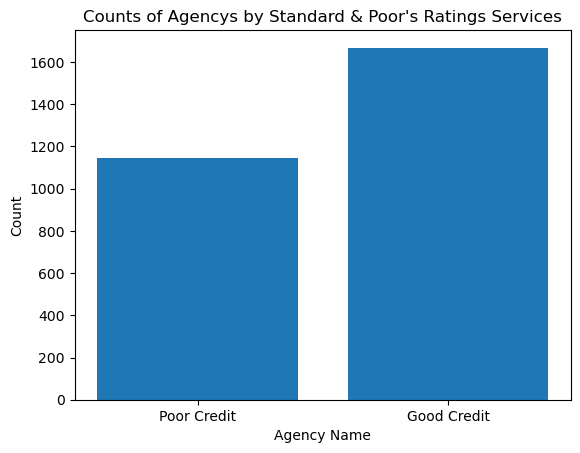

Processing agency: DBRS
a2: DBRS


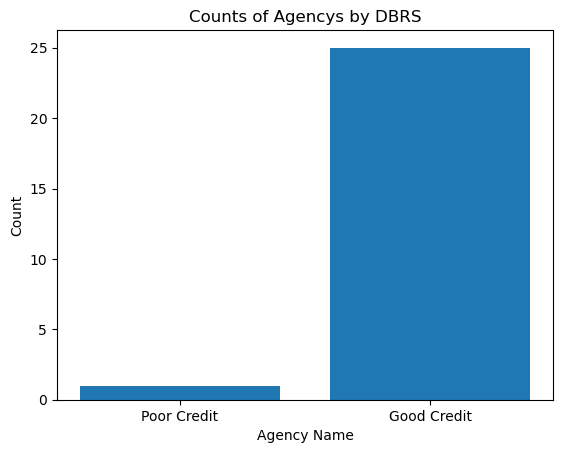

Processing agency: Moody's Investors Service
a2: MoodysInvestorsService


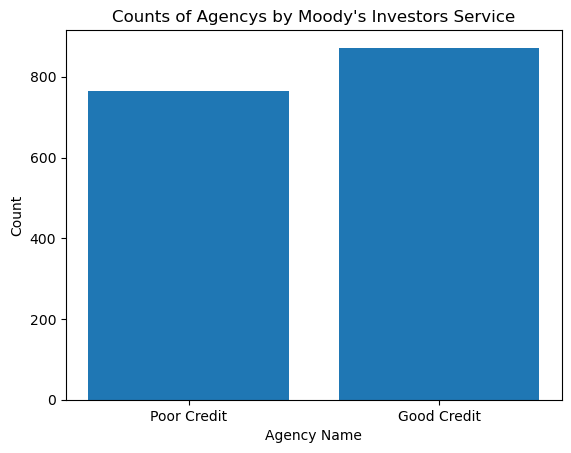

Processing agency: Fitch Ratings
a2: FitchRatings


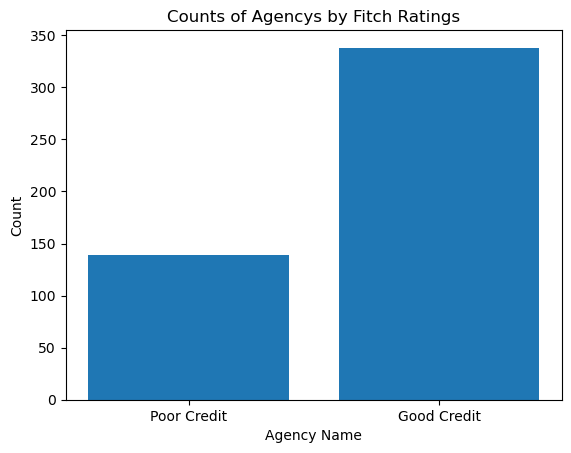

Processing agency: Japan Credit Rating Agency,Ltd.
a2: JapanCreditRatingAgencyLtd


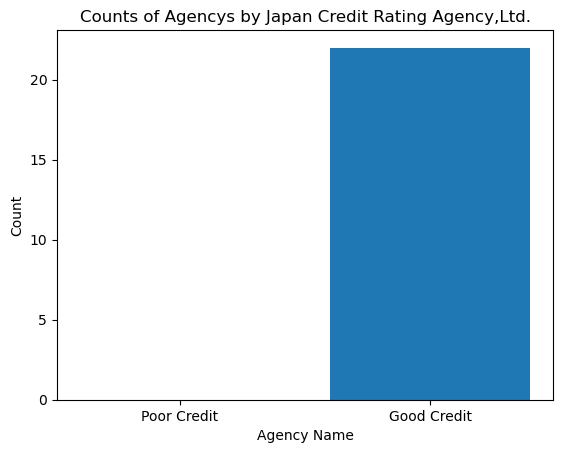

Processing agency: HR Ratings de Mexico S.A. de C.V.
a2: HRRatingsdeMexicoSAdeCV


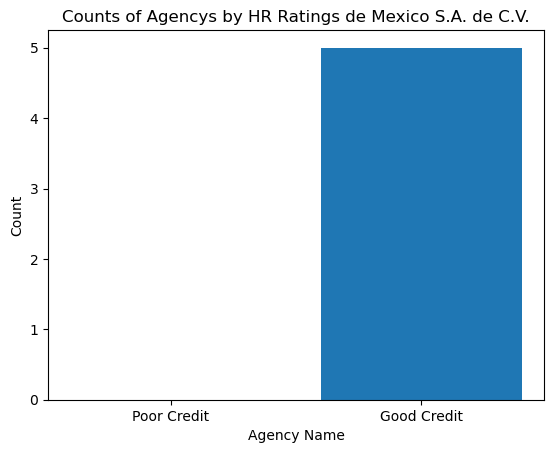

Processing agency: Egan-Jones Ratings Company
a2: EganJonesRatingsCompany


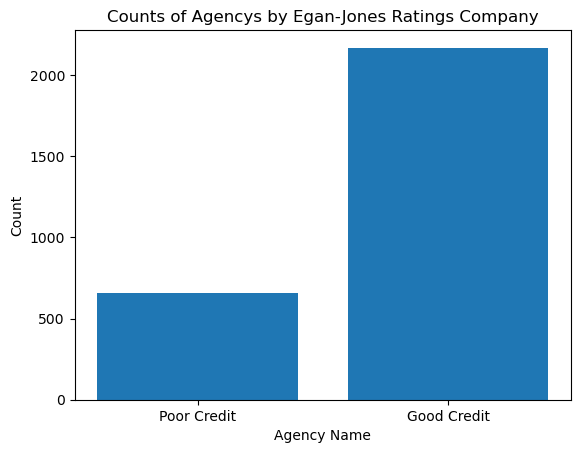

In [31]:
for agency in df['Rating Agency'].unique():
    a2 = re.sub(r'[^\w]', '', agency)
    print(f"Processing agency: {agency}")
    print(f'a2: {a2}')

    agency_Chart(agency, a2)

In [32]:
df['Rating Agency'].value_counts()

Rating Agency
Egan-Jones Ratings Company            2826
Standard & Poor's Ratings Services    2813
Moody's Investors Service             1636
Fitch Ratings                          477
DBRS                                    26
Japan Credit Rating Agency,Ltd.         22
HR Ratings de Mexico S.A. de C.V.        5
Name: count, dtype: int64

In [33]:
agency_counts = df['Rating Agency'].value_counts()

# Create a dictionary with incremental numeric values
agencyDict = {}
count = 1
for agency in agency_counts.index:
    agencyDict[agency] = count
    count += 1

df['Rating Agency'] = df['Rating Agency'].replace(agencyDict)
df.sample(10)

,Rating Agency,Corporation,Rating,Rating Date,CIK,Binary Rating,SIC Code,Sector,Ticker,Current Ratio,...,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
4329,3,"Rent-A-Center, Inc.",B+,2014-02-04,933036,0,7350.0,1,RCII,2.9141,...,31.7507,6.7290,4.1615,1.0251,9.6384,-341.9938,4.2661,5.7171,-1.2326,-1.1943
5480,1,EXXON MOBIL CORPORATION,AA+,2015-08-20,34088,1,2911.0,6,XOM,0.8269,...,17.0910,13.1684,7.4340,1.2637,18.5313,18.5313,9.6445,17.8498,-1.9732,-2.1872
7131,4,"Darden Restaurants, Inc.",BBB,2016-04-15,940944,1,5812.0,5,DRI,0.8828,...,10.2824,2.5917,10.4894,1.1283,8.4165,22.1545,3.2762,5.1878,2.5712,3.7649
6523,1,TE CONNECTIVITY LTD,A+,2015-07-27,1385157,1,3678.0,3,TEL,2.2236,...,19.6776,14.6997,14.8751,0.5941,17.9075,38.4286,8.0091,13.1284,0.1583,0.2664
4973,2,Automatic Data Processing Inc.,AAA,2015-08-28,8670,1,7374.0,3,ADP,1.0625,...,21.8695,18.9304,13.2788,0.3304,28.6264,54.8013,4.1573,28.5717,0.3786,0.4243
7785,2,Xerox Corp.,BBB,2016-04-26,108772,1,7389.0,1,XRX,1.4605,...,16.4445,8.5969,7.9896,0.4584,9.7833,395.4887,3.8036,6.0404,-0.6035,0.0164
280,2,PepsiCo Inc.,A-,2011-10-21,77476,1,2080.0,8,PEP,1.1055,...,18.4291,14.2329,10.9167,0.8486,29.3630,-90.6335,9.2997,15.2815,0.9248,0.2721
429,3,"Amkor Technology, Inc.",BB-,2012-06-15,1047127,0,3674.0,3,AMKR,1.3754,...,23.8771,8.5443,7.8756,1.0741,36.4621,37.2534,8.4824,12.5424,0.9263,0.1768
3840,2,Koppers Holdings Inc.,BB,2014-05-13,1315257,0,2860.0,10,KOP,2.4249,...,8.7939,5.2087,2.7396,1.8834,21.1802,38.3222,5.1217,8.1558,1.9321,-0.1892
808,3,Grifols S.A.,BB-,2012-06-15,1438569,0,2836.0,7,GRFS,2.9861,...,23.0535,4.4564,2.7970,0.3092,8.6908,-11.6844,2.4915,3.2341,0.5512,0.6089


## Save to a database

In [34]:
# Create a database
conn = sqlite3.connect('../data/db.sqlite')
conn.close()

# Connect to the database
conn = sqlite3.connect('../data/db.sqlite')

reduced_df = df.drop(columns=['Corporation', 'Rating', 'CIK', 'Ticker', 'SIC Code', 'Rating Date'])
dummies = pd.get_dummies(reduced_df.dropna(axis=1))  

df.to_sql('ratings', conn, index=False, if_exists='replace', dtype={'id': 'INTEGER PRIMARY KEY'})
reduced_df.to_sql('clean', conn, index=False, if_exists='replace', dtype={'id': 'INTEGER PRIMARY KEY'})
dummies.to_sql('dummies', conn, index=False, if_exists='replace', dtype={'id': 'INTEGER PRIMARY KEY'})

conn.close()